## 0. Initialization

In [1]:
import torch as tc
tc.set_default_dtype(tc.float64)

In [2]:
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d
import camb
import dCl
from joblib import Parallel, delayed
import time

%load_ext autoreload
%autoreload 1
%aimport dCl

In [3]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 16,
})

In [4]:
Nz = 8
zmin = 0.3
zmax = 1.0
zmin_text = '{:.2f}'.format(zmin)
zmax_text = '{:.2f}'.format(zmax)
zlist = tc.linspace(zmin, zmax, Nz)
dCl_obj = dCl.Cl_kSZ2_HI2(zlist)

l_list = tc.hstack([tc.linspace(30, 300, 19), tc.linspace(330, 600, 10)])
pz_list = 10.**tc.linspace(-3,-1, 16)

params = []
for l in l_list:
    for pz in pz_list:
        params.append([l, pz])

print('redshift from ' + zmin_text + ' to ' + zmax_text)
# params = tc.tensor(params).reshape([len(l_list)*len(pz_list), 2])

Note: redshifts have been re-sorted (earliest first)


Note: redshifts have been re-sorted (earliest first)


redshift from 0.30 to 1.00


## 1. Run the code to get dCl data

### dCl : $\mathrm{kSZ}^2 \times \mathrm{HI}^2$ cross-correlation

In [5]:
l_list = tc.hstack([tc.linspace(30, 300, 19), tc.linspace(330, 600, 10)])
t1_list = tc.linspace(0, tc.pi, 31)
l1_list = tc.linspace(100, 10000, 34)

N_JOBS = 4
do_parallel = True

zstart = 0
zend = 1 #len(zlist)
params = []
for l in l_list:
    for l1 in l1_list:
        params.append([l, l1])

def compute(zindex, l, l1, t1):
    res = dCl_obj.dCl_Term(zindex, l, l1, t1)
    return res

In [6]:
length_p = len(params)
length_total = length_p * (zend - zstart)
length100 = length_total / 100
time0 = time.time()

for zindex in range(zstart, zend):
    res_zi = []
    for i, p in enumerate(params[:2]):
        l, l1 = p
        chi = dCl_obj.chi_of_z[zindex]

        if do_parallel:
            res_i_p = Parallel(n_jobs=N_JOBS, prefer='threads')(
                delayed(compute)(zindex, l, l1, t1) 
                    for t1 in t1_list)
            res_zi.append(res_i_p)

        else:
            for t1 in t1_list:
                res_i = compute(zindex, l, l1, t1)
                res_zi.append(res_i)

        time_i = time.time() - time0
        total_index = (zindex - zstart) * length_p + i
        print(' ', total_index, ' of ', length_total, 
            ' percent: {:.3f}%'.format((total_index+1)/length100), 
            ', average velocity: {:.4f}% per min'.format((total_index+1)/length100 * 60. / time_i), 
            '    ', end='\r')
    
    print(' ')
    res_w = tc.tensor(res_zi).reshape([len(l_list), len(l1_list), len(t1_list)])
    print('saving data...')
    np.save('Data/Cross_z_' + zmin_text + '_' + zmax_text + f'/dCl_cross_{zindex}.npy', res_w)


KeyboardInterrupt: 

### dCl :  $\mathrm{HI}$ and $\mathrm{HI}^2$ auto-correlation

In [ ]:
Tsys = 22           # K
deltaNu = 2e5       # Hz
Ddish = 13.5        # m
wavelength = 0.21   # m
theta_b = 1.02 * wavelength / Ddish * 180/np.pi # deg
As = 8000           # deg^2

Ntot = 197          # 64 dishes for MeerKAT and 197 dishes for SKA-MID
Tobs = 1e4 * 3600   # s
Skycover = 20000    # deg^2
Ttot = Ntot * (As / Skycover) * Tobs # seconds


thermal_noise = Tsys**2 / (deltaNu * Ttot) * (4/np.pi)**2 * (As/theta_b**2)
print(r'$\sigma_\mathrm{T}^2$ at $z=0$ :', thermal_noise, r'$\mathrm{K}^2$')

zz = dCl_obj.z_array - (1+dCl_obj.z_array)**2 * 0.2 / 1420.
dz = dCl_obj.chi_of_z - tc.tensor(dCl_obj.results.comoving_radial_distance(zz))
volume = (theta_b * np.pi / 180. * dCl_obj.chi_of_z)**2 * dz
print(r'The volume of pixel at different redshifts are ', volume, 'Mpc^3')

$\sigma_\mathrm{T}^2$ at $z=0$ : 1.3386905916387097e-08 $\mathrm{K}^2$
The volume of pixel at different redshifts are  tensor([ 343.1347,  632.5214, 1012.0041, 1477.1676, 2021.4597, 2637.2380,
        3316.5296, 4051.5351]) Mpc^3


In [6]:
res_beam = tc.empty([Nz, len(l_list)])
res_nobeam = tc.empty([Nz, len(l_list)])

for zi in range(Nz):
    for li in range(len(l_list)):
        res_nobeam[zi, li], res_beam[zi, li] = dCl_obj.dCl_HI2(zi=zi, l=l_list[li], beam='both', noise = thermal_noise * volume[zi])

print(res_beam.shape)

np.save('Data/HI2_z_' + zmin_text + '_' + zmax_text + '/dCl_HI2.npy', res_beam)
np.save('Data/HI2_z_' + zmin_text + '_' + zmax_text + '/dCl_HI2_nobeam.npy', res_nobeam)

torch.Size([8, 29])


In [7]:
res_beam_nonoise = tc.empty([Nz, len(l_list)])
res_nobeam_nonoise = tc.empty([Nz, len(l_list)])

for zi in range(Nz):
    for li in range(len(l_list)):
        res_nobeam_nonoise[zi, li], res_beam_nonoise[zi, li] = dCl_obj.dCl_HI2(zi=zi, l=l_list[li], beam='both', noise = 0.)

np.save('Data/HI2_z_' + zmin_text + '_' + zmax_text + '/dCl_HI2_nonoise.npy', res_beam_nonoise)
np.save('Data/HI2_z_' + zmin_text + '_' + zmax_text + '/dCl_HI2_nobeam_nonoise.npy', res_nobeam_nonoise)

### dCl :  $\mathrm{kSZ}$ and $\mathrm{kSZ}^2$ auto-correlation

In [101]:
zmax, Nzksz = 12, 100
kSZ_obj = dCl.Cl_kSZ2(zmax=zmax, zmin=0.001, Nz=Nzksz, nonlinear=True)
l_list = tc.tensor(np.geomspace(10, 1e5, 101))

Note: redshifts have been re-sorted (earliest first)


In [ ]:
l_list = tc.tensor(np.geomspace(10, 1e5, 101))
Cl_kSZ = tc.empty_like(l_list)

for i, l in enumerate(l_list):
    Cl_kSZ[i] = kSZ_obj.Cl_kSZ(l, beam=True)
    print(i, l, '   ', end='\r')

Cl_kSZ_nobeam = Cl_kSZ / kSZ_obj.Beam_kSZ(l_list)**2

np.save('Data/kSZ_effect/Cl_kSZ.npy', Cl_kSZ)
np.save('Data/kSZ_effect/Cl_kSZ_nobeam.npy', Cl_kSZ_nobeam)

In [ ]:
Cl_kSZ = tc.tensor(np.load('Data/kSZ_effect/Cl_kSZ.npy'))
Cl_kSZ_nobeam = Cl_kSZ / kSZ_obj.Beam_kSZ(l_list)**2
CL_kSZ2 = kSZ_obj.Cl_kSZ2(l_list=l_list, Cl_kSZ=Cl_kSZ)
np.save('Data/kSZ_effect/CL_kSZ2.npy', np.array(CL_kSZ2))

In [6]:
#############################################
# Run the filter generation in next section before the code below

Cl_kSZ = tc.tensor(np.load('Data/kSZ_effect/Cl_kSZ.npy'))
Cl_kSZ_nobeam = Cl_kSZ / kSZ_obj.Beam_kSZ(l_list)**2

l_list = tc.tensor(np.geomspace(10, 1e5, 101))
ls_and_Fl = np.load('Data/Fl_and_l_kSZ.npy')
ls = ls_and_Fl[0]
Fl = ls_and_Fl[1]
def get_filter(l):
    return np.interp(l, ls, Fl)

Cl_kSZ_filtered = np.hstack([[0., 0.], np.load('Data/kSZ_effect/Cl_kSZ_filtered.npy'), [0., 0.]])

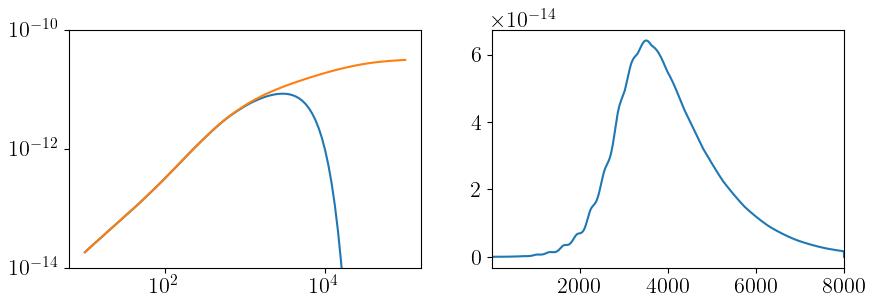

In [7]:
fig = plt.figure(figsize=(10,3.09))

plt.subplot(1,2,1)
plt.plot(l_list, l_list * (l_list + 1) * Cl_kSZ * (2.7)**2)
plt.plot(l_list, l_list * (l_list + 1) * Cl_kSZ_nobeam * (2.7)**2)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-14, 1e-10])

plt.subplot(1,2,2)
plt.plot(ls, ls * (ls + 1) * Cl_kSZ_filtered)
plt.xlim([1,8000])

plt.show()

In [ ]:
ls_short = ls[::40]
Cl_kSZ_filtered_short = Cl_kSZ_filtered[::40]
CL_kSZ2 = kSZ_obj.Cl_kSZ2(l_list=tc.tensor(ls_short), Cl_kSZ=tc.tensor(Cl_kSZ_filtered_short), ll_max=1e4, log=False)
np.save('Data/kSZ_effect/CL_kSZ2_filtered.npy', np.array(CL_kSZ2))

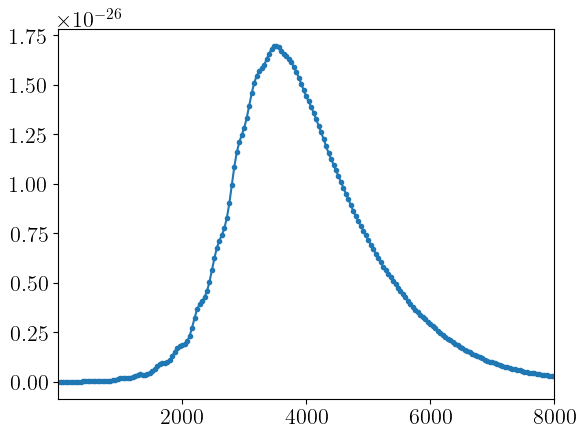

In [ ]:
plt.plot(ls_short, ls_short * (ls_short + 1) * np.array(CL_kSZ2), '.-')
plt.xlim([1,8000])
plt.show()

In [104]:
#############################################
# Filtered kSZ for different observations

for ob in ['SO', 'CMBS4', 'CMBHD']:

    Cl_kSZ = tc.tensor(np.load('Data/kSZ_effect/Cl_kSZ.npy'))
    Cl_kSZ_nobeam = Cl_kSZ / kSZ_obj.Beam_kSZ(l_list)**2

    l_list = tc.tensor(np.geomspace(10, 1e5, 101))
    ls_and_Fl = np.load('Data/Fl_and_l_kSZ_' + ob + '.npy')
    ls = ls_and_Fl[0]
    Fl = ls_and_Fl[1]
    def get_filter(l):
        return np.interp(l, ls, Fl)

    Cl_kSZ_filtered = np.hstack([[0., 0.], np.load('Data/kSZ_effect/Cl_kSZ_filtered_' + ob + '.npy'), [0., 0.]])

    ls_short = ls[::40]
    Cl_kSZ_filtered_short = Cl_kSZ_filtered[::40]
    CL_kSZ2 = kSZ_obj.Cl_kSZ2(l_list=tc.tensor(ls_short), Cl_kSZ=tc.tensor(Cl_kSZ_filtered_short), ll_max=1e4, log=False)
    np.save('Data/kSZ_effect/CL_kSZ2_filtered_' + ob + '.npy', np.array(CL_kSZ2))

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_croot-udngs7fm/pytorch_1648016055234/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


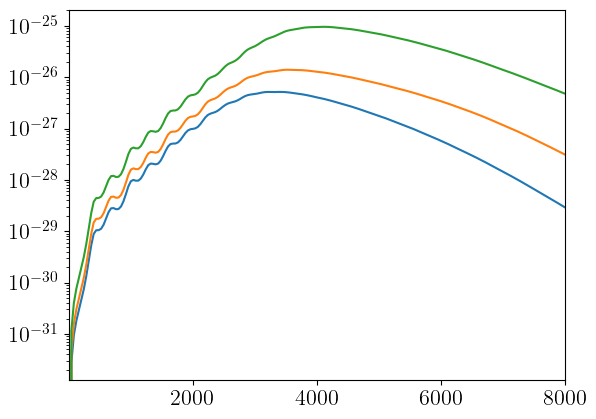

In [105]:
for ob in ['SO', 'CMBS4', 'CMBHD']:
    CL_kSZ2 = np.load('Data/kSZ_effect/CL_kSZ2_filtered_' + ob + '.npy')
    plt.plot(ls_short, ls_short * (ls_short + 1) * np.array(CL_kSZ2), '-')
    plt.yscale('log')
plt.xlim([1,8000])
plt.show()

#### linear model

In [48]:
zmax, Nzksz = 12, 100
kSZ_obj = dCl.Cl_kSZ2(zmax=zmax, zmin=0.001, Nz=Nzksz, nonlinear=False)

Note: redshifts have been re-sorted (earliest first)


In [ ]:
l_list = tc.tensor(np.geomspace(10, 1e5, 101))

Cl_kSZ = tc.empty_like(l_list)

for i, l in enumerate(l_list):
    Cl_kSZ[i] = kSZ_obj.Cl_kSZ(l, beam=True)
    print(i, l, '   ', end='\r')

Cl_kSZ_nobeam = Cl_kSZ / kSZ_obj.Beam_kSZ(l_list)**2

np.save('Data/kSZ_effect/Cl_kSZ_linear.npy', Cl_kSZ)
np.save('Data/kSZ_effect/Cl_kSZ_nobeam_linear.npy', Cl_kSZ_nobeam)

In [57]:
Cl_kSZ = tc.tensor(np.load('Data/kSZ_effect/Cl_kSZ_linear.npy'))
Cl_kSZ_nobeam = tc.tensor(np.load('Data/kSZ_effect/Cl_kSZ_nobeam_linear.npy'))
CL_kSZ2 = kSZ_obj.Cl_kSZ2(l_list=l_list, Cl_kSZ=Cl_kSZ)
np.save('Data/kSZ_effect/CL_kSZ2_linear.npy', np.array(CL_kSZ2))

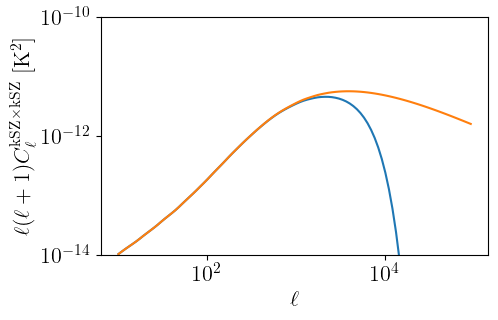

In [58]:
fig = plt.figure(figsize=(5, 3.09), dpi=100)

# times (2.7K)^2 to convert to temperature unit
xi, xe = 0, -1
plt.plot(l_list[xi:xe], (l_list * (l_list + 1) * Cl_kSZ)[xi:xe] * (2.7)**2, '-', label='with beam')
plt.plot(l_list[xi:xe], (l_list * (l_list + 1) * Cl_kSZ_nobeam)[xi:xe] * (2.7)**2, '-', label='no beam')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-14, 1e-10])

plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'$\ell(\ell+1)C_{\ell}^{{\rm kSZ} \times {\rm kSZ}}$ [$\mathrm{K}^2$]', usetex=True)

plt.show()

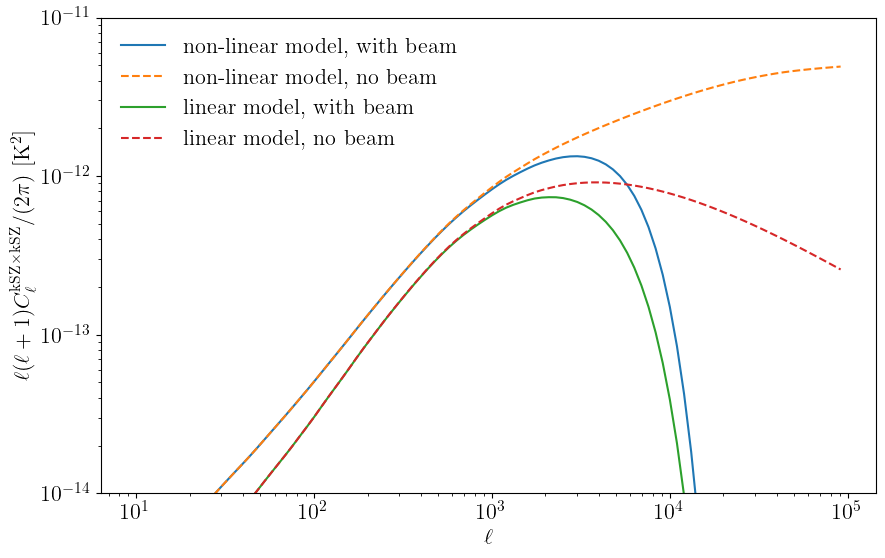

In [ ]:
l_list_kSZ = tc.tensor(np.geomspace(10, 1e5, 101))

# times (2.7K)^2 to convert to temperature unit
Cl_kSZ = tc.tensor(np.load('Data/kSZ_effect/Cl_kSZ.npy')) * (2.7)**2 
Cl_kSZ_nobeam = Cl_kSZ / dCl_obj.Beam_kSZ(l_list_kSZ)**2

Cl_kSZ_linear = tc.tensor(np.load('Data/kSZ_effect/Cl_kSZ_linear.npy'))* (2.7)**2
Cl_kSZ_nobeam_linear = Cl_kSZ_linear / dCl_obj.Beam_kSZ(l_list_kSZ)**2


fig = plt.figure(figsize=(10, 6.18), dpi=100)

xi, xe = 0, -1
plt.plot(l_list_kSZ[xi:xe], (l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ)[xi:xe] / (2*np.pi), '-', label='non-linear model, with beam')
plt.plot(l_list_kSZ[xi:xe], (l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ_nobeam)[xi:xe] / (2*np.pi), '--', label='non-linear model, no beam')

plt.plot(l_list_kSZ[xi:xe], (l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ_linear)[xi:xe] / (2*np.pi), '-', label='linear model, with beam')
plt.plot(l_list_kSZ[xi:xe], (l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ_nobeam_linear)[xi:xe] / (2*np.pi), '--', label='linear model, no beam')

plt.legend(fontsize=16, frameon=False)

plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-14, 1e-11])

plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'$\ell(\ell+1)C_{\ell}^{{\rm kSZ} \times {\rm kSZ}} / (2\pi)$ [$\mathrm{K}^2$]', usetex=True)

# plt.savefig('Cl_kSZ.pdf', bbox_inches = 'tight')
plt.show()

### dCl: Comparison  kSZ total  v.s.  kSZ within 0.3<z<1

In [9]:
zmin1, zmax1, Nzksz1 = 0.3, 1.0, 30
kSZ_obj = dCl.Cl_kSZ2(zmax=zmax1, zmin=zmin1, Nz=Nzksz1, nonlinear=True)

Note: redshifts have been re-sorted (earliest first)


In [ ]:
l_list = tc.tensor(np.geomspace(10, 1e5, 101))
Cl_kSZ_nobeam = tc.empty_like(l_list)
for i, l in enumerate(l_list):
    Cl_kSZ_nobeam[i] = kSZ_obj.Cl_kSZ(l, beam=False)
    print(i, l, '   ', end='\r')

Cl_kSZ = Cl_kSZ_nobeam * kSZ_obj.Beam_kSZ(l_list)**2

np.save('Data/kSZ_effect/Cl_kSZ_0.3-1.0.npy', Cl_kSZ)
np.save('Data/kSZ_effect/Cl_kSZ_nobeam_0.3-1.0.npy', Cl_kSZ_nobeam)

In [ ]:
Cl_kSZ_test = tc.tensor(np.load('Data/kSZ_effect/Cl_kSZ_0.3-1.0.npy'))
Cl_kSZ_test_nobeam = tc.tensor(np.load('Data/kSZ_effect/Cl_kSZ_nobeam_0.3-1.0.npy'))
CL_kSZ2_test = kSZ_obj.Cl_kSZ2(l_list=l_list, Cl_kSZ=Cl_kSZ_test)
np.save('Data/kSZ_effect/CL_kSZ2_0.3-1.0.npy', np.array(CL_kSZ2_test))

In [33]:
ltot_list = tc.tensor(np.geomspace(10, 1e5, 101))
Cl_kSZ_tot = tc.tensor(np.load('Data//kSZ_effect/Cl_kSZ.npy'))
Cl_kSZ_tot_nobeam = tc.tensor(np.load('Data/kSZ_effect/Cl_kSZ_nobeam.npy'))
Cl_kSZ_test = tc.tensor(np.load('Data/kSZ_effect/Cl_kSZ_0.3-1.0.npy'))
Cl_kSZ_test_nobeam = tc.tensor(np.load('Data/kSZ_effect/Cl_kSZ_nobeam_0.3-1.0.npy'))

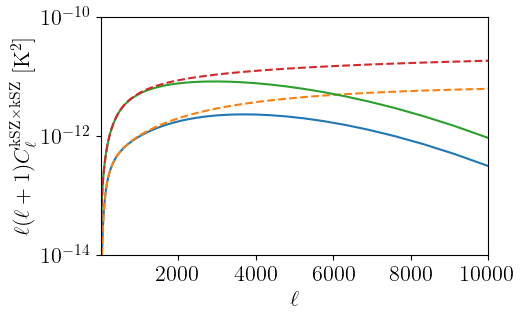

In [34]:
fig = plt.figure(figsize=(5, 3.09), dpi=100)

# times (2.7K)^2 to convert to temperature unit
xi, xe = 0, -1
plt.plot(l_list[xi:xe], (l_list * (l_list + 1) * Cl_kSZ_test)[xi:xe] * (2.7)**2, '-', label='late-time kSZ with beam')
plt.plot(l_list[xi:xe], (l_list * (l_list + 1) * Cl_kSZ_test_nobeam)[xi:xe] * (2.7)**2, '--', label='late-time kSZ no beam')

plt.plot(ltot_list[xi:xe], (ltot_list * (ltot_list + 1) * Cl_kSZ_tot)[xi:xe] * (2.7)**2, '-', label='total kSZ with beam')
plt.plot(ltot_list[xi:xe], (ltot_list * (ltot_list + 1) * Cl_kSZ_tot_nobeam)[xi:xe] * (2.7)**2, '--', label='total kSZ no beam')

# plt.legend()

plt.xlim([10, 1e4])
# plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-14, 1e-10])

plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'$\ell(\ell+1)C_{\ell}^{{\rm kSZ} \times {\rm kSZ}}$ [$\mathrm{K}^2$]', usetex=True)

# plt.savefig('Cl_HI2.pdf', bbox_inches = 'tight')
plt.show()

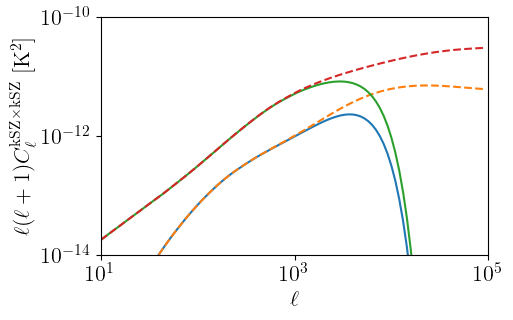

In [37]:
fig = plt.figure(figsize=(5, 3.09), dpi=100)

# times (2.7K)^2 to convert to temperature unit
xi, xe = 0, -1
plt.plot(l_list[xi:xe], (l_list * (l_list + 1) * Cl_kSZ_test)[xi:xe] * (2.7)**2, '-', label='late-time kSZ with beam')
plt.plot(l_list[xi:xe], (l_list * (l_list + 1) * Cl_kSZ_test_nobeam)[xi:xe] * (2.7)**2, '--', label='late-time kSZ no beam')

plt.plot(ltot_list[xi:xe], (ltot_list * (ltot_list + 1) * Cl_kSZ_tot)[xi:xe] * (2.7)**2, '-', label='total kSZ with beam')
plt.plot(ltot_list[xi:xe], (ltot_list * (ltot_list + 1) * Cl_kSZ_tot_nobeam)[xi:xe] * (2.7)**2, '--', label='total kSZ no beam')

# plt.legend()

plt.xlim([10, 1e5])
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-14, 1e-10])

plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'$\ell(\ell+1)C_{\ell}^{{\rm kSZ} \times {\rm kSZ}}$ [$\mathrm{K}^2$]', usetex=True)

# plt.savefig('Cl_HI2.pdf', bbox_inches = 'tight')
plt.show()

## 2. Filter effects on kSZ

In [5]:
H0 = 67.75
ombh2 = 0.022

# params = camb.CAMBparams()
params = camb.set_params(H0=H0, ombh2=ombh2, lmax=8000)

results = camb.get_results(params)
CMB_angular = results.get_cmb_power_spectra(params, CMB_unit='K')
Dl_TT = CMB_angular['total'][2:-50,0] * 2 * np.pi   # Dl is defined as l(l+1)Cl
ls = np.arange(CMB_angular['total'].shape[0])[2:-50]

### post-ILC noise

In [6]:
from orphics import foregrounds as fg

In [ ]:
# post-ILC noise power for each observation, in unit muk^2
ls_so, Nl_so_long = fg.get_ilc_noise('so', scale_noise=1)
ls_s4, Nl_s4_long = fg.get_ilc_noise('s4', scale_noise=1)
ls_hd, Nl_hd_long = fg.get_ilc_noise('hd', scale_noise=1)

Populating covariance for  39.0 x 39.0
Populating covariance for  39.0 x 93.0
Populating covariance for  39.0 x 145.0
Populating covariance for  39.0 x 225.0


/Users/jiangyuer/Desktop/Works/0 kSZ effect/Codes/packages/szar/szar/foregrounds.py:183: UserWarning: Warning: Requested ells go higher than available. Extrapolating above highest ell.
  warnings.warn("Warning: Requested ells go higher than available." + \
/Users/jiangyuer/Desktop/Works/0 kSZ effect/Codes/packages/szar/szar/foregrounds.py:73: RuntimeWarning: overflow encountered in multiply
  return yy * ffunc(nu1) * ffunc(nu2) * tcmb**2.


Populating covariance for  39.0 x 280.0
Populating covariance for  93.0 x 39.0
Populating covariance for  93.0 x 93.0
Populating covariance for  93.0 x 145.0
Populating covariance for  93.0 x 225.0
Populating covariance for  93.0 x 280.0
Populating covariance for  145.0 x 39.0
Populating covariance for  145.0 x 93.0
Populating covariance for  145.0 x 145.0
Populating covariance for  145.0 x 225.0
Populating covariance for  145.0 x 280.0
Populating covariance for  225.0 x 39.0
Populating covariance for  225.0 x 93.0
Populating covariance for  225.0 x 145.0
Populating covariance for  225.0 x 225.0
Populating covariance for  225.0 x 280.0
Populating covariance for  280.0 x 39.0
Populating covariance for  280.0 x 93.0
Populating covariance for  280.0 x 145.0
Populating covariance for  280.0 x 225.0
Populating covariance for  280.0 x 280.0
Populating covariance for  39.0 x 39.0
Populating covariance for  39.0 x 93.0
Populating covariance for  39.0 x 145.0
Populating covariance for  39.0 x 2

In [14]:
# interpolation and transfer into unit K^2
Nl_so = np.interp(ls, ls_so, Nl_so_long) * 1e-12
Nl_s4 = np.interp(ls, ls_so, Nl_s4_long) * 1e-12
Nl_hd = np.interp(ls, ls_so, Nl_hd_long) * 1e-12

np.save('Data/ILC-Nl_SO.npy', Nl_so)
np.save('Data/ILC-Nl_CMBS4.npy', Nl_s4)
np.save('Data/ILC-Nl_CMBHD.npy', Nl_hd)

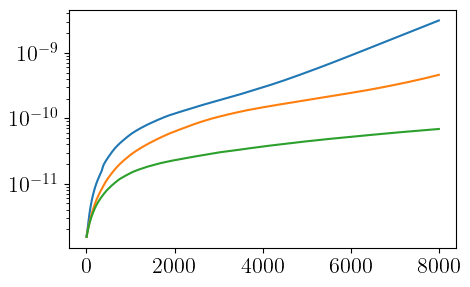

In [13]:
fig = plt.figure(figsize=(5,3.09))
plt.plot(ls, ls*(ls+1)*Nl_so)
plt.plot(ls, ls*(ls+1)*Nl_s4)
plt.plot(ls, ls*(ls+1)*Nl_hd)
plt.yscale('log')
plt.show()

### ACT

In [15]:
H0 = 67.75
ombh2 = 0.022

# params = camb.CAMBparams()
params = camb.set_params(H0=H0, ombh2=ombh2, lmax=8000)

results = camb.get_results(params)
CMB_angular = results.get_cmb_power_spectra(params, CMB_unit='K')
Dl_TT = CMB_angular['total'][2:-50,0] * 2 * np.pi   # Dl is defined as l(l+1)Cl
ls = np.arange(CMB_angular['total'].shape[0])[2:-50]

In [16]:
DeltaT = 1e-5 * np.pi / 180 / 60 # in unit of K

beam = np.array(dCl_obj.Beam_kSZ(tc.tensor(ls)))
Nl = DeltaT**2 * beam**(-2)

l_list_kSZ = tc.tensor(np.geomspace(10, 1e5, 101))
Cl_kSZ = tc.tensor(np.load('Data/kSZ_effect/Cl_kSZ.npy')) * (2.7)**2 
Cl_kSZ_nobeam = Cl_kSZ / dCl_obj.Beam_kSZ(l_list_kSZ)**2

def Cl_kSZ_itp(llist):
    return np.interp(llist, l_list_kSZ, Cl_kSZ_nobeam)

ClkSZ_itp = Cl_kSZ_itp(ls)
fl = ClkSZ_itp / (ClkSZ_itp + Dl_TT/(ls* (ls + 1)) + Nl) # * beam

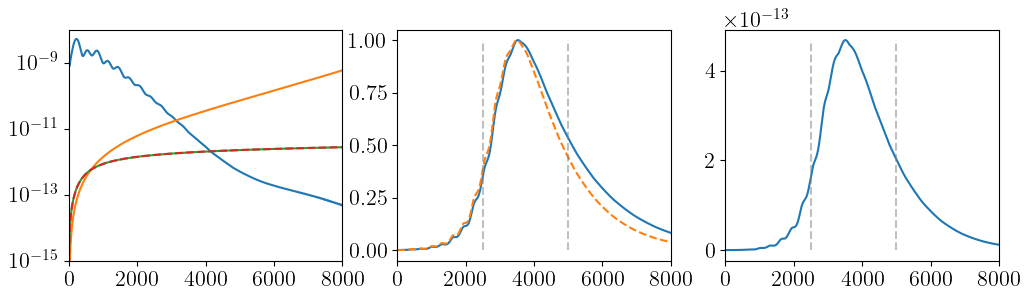

In [17]:
fig = plt.figure(figsize=(12,3))

plt.subplot(1,3,1)

plt.plot(ls, Dl_TT / (2*np.pi))
plt.plot(ls, ls*(ls+1)*Nl / (2*np.pi))
plt.plot(l_list_kSZ, l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ_nobeam / (2*np.pi))
plt.plot(ls, ls*(ls+1)*ClkSZ_itp / (2*np.pi), '--')

# plt.xscale('log')
plt.yscale('log')

plt.xlim([0, 8000])
plt.ylim([1e-15, 1e-8])

plt.subplot(1,3,2)
plt.plot(ls, fl / np.max(fl))
plt.plot(ls, fl * beam / np.max(fl*beam), '--')
plt.vlines([2500, 5000], ymin=0, ymax=1, colors='gray', alpha=0.5, linestyles='--')
plt.xlim([0,8000])

plt.subplot(1,3,3)
Dl_kSZ_filtered = fl**2 * beam**2 * ( Dl_TT + ls*(ls+1)*(Nl + ClkSZ_itp) )
plt.plot(ls,  Dl_kSZ_filtered)
plt.vlines([2500, 5000], ymin=0, ymax=np.max(Dl_kSZ_filtered), colors='gray', alpha=0.5, linestyles='--')
plt.xlim([0,8000])

plt.show()

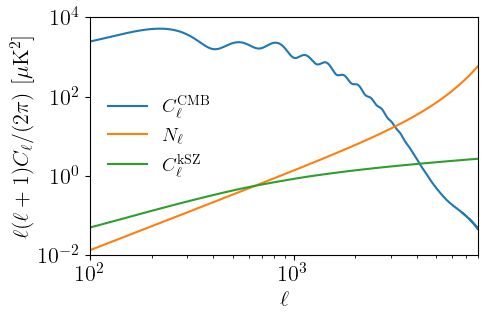

In [18]:
fig = plt.figure(figsize=(5,3.09), dpi=100)

plt.plot(ls, Dl_TT / (2*np.pi) * 1e12, label = r'$C_{\ell}^{\mathrm{CMB}}$')
plt.plot(ls, ls*(ls+1)*Nl * 1e12 / (2*np.pi) , label = r'$N_{\ell}$')
plt.plot(l_list_kSZ, l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ_nobeam / (2*np.pi) * 1e12, label = r'$C_{\ell}^{\mathrm{kSZ}}$')
# plt.plot(ls, ls*(ls+1)*ClkSZ_itp / (2*np.pi) * 1e12, '--')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell (\ell + 1) C_\ell / (2\pi) ~ [\mu \mathrm{K}^2] $')

plt.xlim([100, 8000])
plt.ylim([1e-2, 1e4])
plt.legend(fontsize=14, frameon=False)

plt.savefig('Figs/Cl_kSZ.pdf', bbox_inches = 'tight')

plt.show()

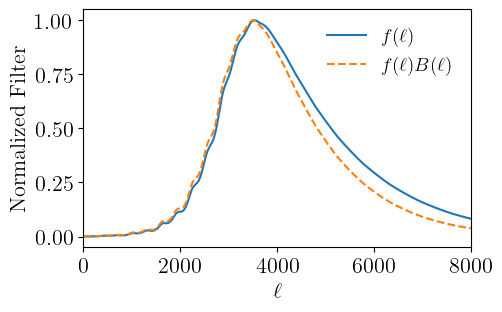

In [19]:
fig = plt.figure(figsize=(5,3.09), dpi=100)

plt.plot(ls, fl / np.max(fl), label=r'$f(\ell)$')
plt.plot(ls, fl * beam / np.max(fl*beam), '--', label=r'$f(\ell)B(\ell)$')

plt.xlabel(r'$\ell$')
plt.ylabel(r'Normalized Filter')

plt.xlim([0, 8000])
plt.legend(fontsize=14, frameon=False)

plt.savefig('Figs/Filter.pdf', bbox_inches = 'tight')

plt.show()

In [ ]:
#######################################
# Saving the ell and filter*beam

Fl_and_l_extend = np.vstack([
    np.hstack([[0., 1.], ls, [8001., 1e6]]),
    np.hstack([[0., 0.], fl * beam, [0., 0.]])
])
np.save('Data/Fl_and_l_kSZ.npy', Fl_and_l_extend)

#######################################
# Saving the filtered Cl_kSZ 
Cl_kSZ_filtered = Dl_kSZ_filtered / (ls * (ls + 1)) / (2.7)**2 # dimensionless
np.save('Data/kSZ_effect/Cl_kSZ_filtered.npy', Cl_kSZ_filtered)

##### 3D plots

In [36]:
Cl_and_l_extend = np.vstack([
    np.hstack([[0., 1.], ls, [8001., 1e6]]),
    np.hstack([[0., 0.], fl**2 * beam**2 * ( Dl_TT / (ls*(ls+1)) + Nl + ClkSZ_itp ), [0., 0.]])
])

def get_Cl_filtered(l):
    return np.interp(l, Cl_and_l_extend[0], Cl_and_l_extend[1])

In [37]:
l_max = 10000
lx_list = np.linspace(-l_max, l_max, 300)
ly_list = lx_list
lx, ly = np.meshgrid(lx_list, ly_list)
l1norm = np.sqrt(lx**2 + ly**2)

In [64]:
l_inspection = 2000
Cl1 = get_Cl_filtered(l1norm)

lml1norm = np.sqrt((lx - l_inspection)**2 + ly**2)
Clml1 = get_Cl_filtered(lml1norm)

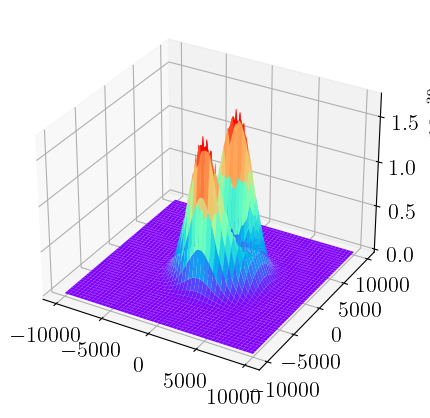

In [65]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(lx, ly, Cl1 * Clml1, cmap='rainbow', edgecolor='none', antialiased=True)
plt.show()

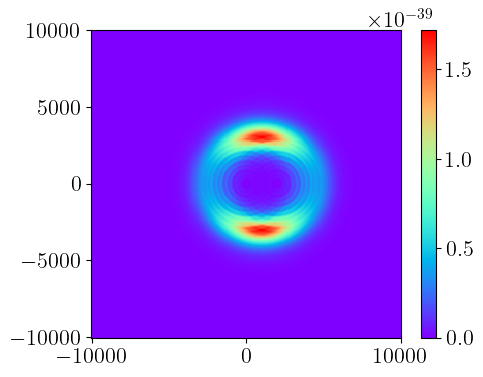

In [67]:
fig = plt.figure(figsize=(5,4))

plt.pcolormesh(lx, ly, Cl1 * Clml1, cmap='rainbow')
plt.colorbar()
# plt.xlim([-5000,5000])
# plt.ylim([-5000,5000])
plt.show()

### SO

In [61]:
ls = np.arange(CMB_angular['total'].shape[0])[2:-50]
DeltaT = np.load('Data/ILC-Nl_SO.npy') # in unit of K

kSZ_obj.set_theta_FWHM_CMB(1.4/60.)
beam = np.array(kSZ_obj.Beam_kSZ(tc.tensor(ls)))
Nl = DeltaT * beam**(-2)

l_list_kSZ = tc.tensor(np.geomspace(10, 1e5, 101))
Cl_kSZ = tc.tensor(np.load('Data/kSZ_effect/Cl_kSZ.npy')) * (2.7)**2 
Cl_kSZ_nobeam = Cl_kSZ / kSZ_obj.Beam_kSZ(l_list_kSZ)**2

def Cl_kSZ_itp(llist):
    return np.interp(llist, l_list_kSZ, Cl_kSZ_nobeam)

ClkSZ_itp = Cl_kSZ_itp(ls)
fl = ClkSZ_itp / (ClkSZ_itp + Dl_TT/(ls* (ls + 1)) + Nl) # * beam

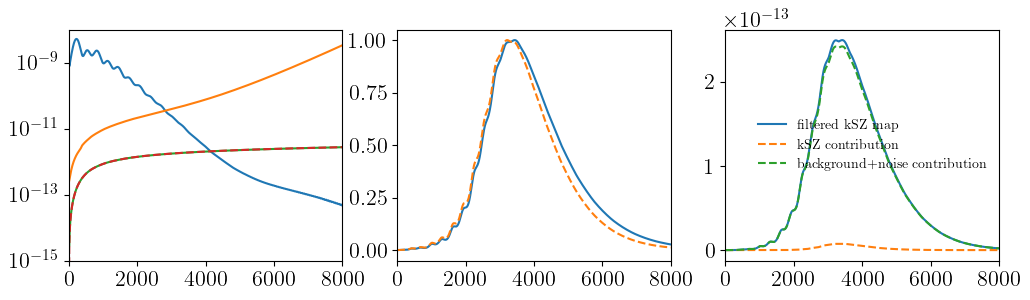

In [62]:
fig = plt.figure(figsize=(12,3))

plt.subplot(1,3,1)

plt.plot(ls, Dl_TT / (2*np.pi))
plt.plot(ls, ls*(ls+1)*Nl / (2*np.pi))
plt.plot(l_list_kSZ, l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ_nobeam / (2*np.pi))
plt.plot(ls, ls*(ls+1)*ClkSZ_itp / (2*np.pi), '--')

plt.yscale('log')

plt.xlim([0, 8000])
plt.ylim([1e-15, 1e-8])

plt.subplot(1,3,2)
plt.plot(ls, fl / np.max(fl))
plt.plot(ls, fl * beam / np.max(fl*beam), '--')
# plt.plot(ls, fl * beam, '-')
# plt.vlines([2500, 5000], ymin=0, ymax=1, colors='gray', alpha=0.5, linestyles='--')
plt.xlim([0,8000])

plt.subplot(1,3,3)
Dl_kSZ_filtered = fl**2 * beam**2 * ( Dl_TT + ls*(ls+1)*(Nl + ClkSZ_itp) )
plt.plot(ls, Dl_kSZ_filtered, label='filtered kSZ map')
plt.plot(ls, fl**2 * beam**2 *ls*(ls+1) * ClkSZ_itp, '--', label='kSZ contribution')
plt.plot(ls, Dl_kSZ_filtered - fl**2 * beam**2 *ls*(ls+1) * ClkSZ_itp, '--', label='background+noise contribution')
plt.legend(fontsize = 10, frameon=False)

plt.xlim([0,8000])

plt.show()

In [63]:
Fl_and_l_extend = np.vstack([
    np.hstack([[0., 1.], ls, [8001., 1e6]]),
    np.hstack([[0., 0.], fl * beam, [0., 0.]])
])
np.save('Data/Fl_and_l_kSZ_SO.npy', Fl_and_l_extend)



Cl_kSZ_filtered = Dl_kSZ_filtered / (ls * (ls + 1)) / (2.7)**2 # dimensionless
np.save('Data/kSZ_effect/Cl_kSZ_filtered_SO.npy', Cl_kSZ_filtered)

### CMB-S4

In [64]:
ls = np.arange(CMB_angular['total'].shape[0])[2:-50]
DeltaT = np.load('Data/ILC-Nl_CMBS4.npy') # in unit of K

kSZ_obj.set_theta_FWHM_CMB(1.4/60.)
beam = np.array(kSZ_obj.Beam_kSZ(tc.tensor(ls)))
Nl = DeltaT * beam**(-2)

l_list_kSZ = tc.tensor(np.geomspace(10, 1e5, 101))
Cl_kSZ = tc.tensor(np.load('Data/kSZ_effect/Cl_kSZ.npy')) * (2.7)**2 
Cl_kSZ_nobeam = Cl_kSZ / kSZ_obj.Beam_kSZ(l_list_kSZ)**2

def Cl_kSZ_itp(llist):
    return np.interp(llist, l_list_kSZ, Cl_kSZ_nobeam)

ClkSZ_itp = Cl_kSZ_itp(ls)
fl = ClkSZ_itp / (ClkSZ_itp + Dl_TT/(ls* (ls + 1)) + Nl) # * beam

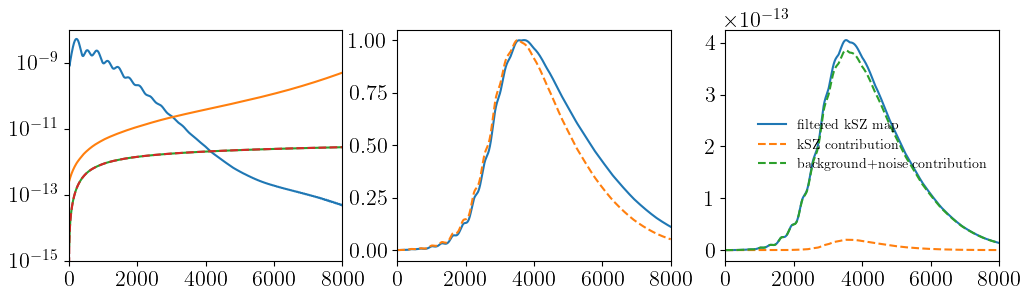

In [65]:
fig = plt.figure(figsize=(12,3))

plt.subplot(1,3,1)

plt.plot(ls, Dl_TT / (2*np.pi))
plt.plot(ls, ls*(ls+1)*Nl / (2*np.pi))
plt.plot(l_list_kSZ, l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ_nobeam / (2*np.pi))
plt.plot(ls, ls*(ls+1)*ClkSZ_itp / (2*np.pi), '--')

plt.yscale('log')

plt.xlim([0, 8000])
plt.ylim([1e-15, 1e-8])

plt.subplot(1,3,2)
plt.plot(ls, fl / np.max(fl))
plt.plot(ls, fl * beam / np.max(fl*beam), '--')
# plt.plot(ls, fl * beam, '-')
# plt.vlines([2500, 5000], ymin=0, ymax=1, colors='gray', alpha=0.5, linestyles='--')
plt.xlim([0,8000])

plt.subplot(1,3,3)
Dl_kSZ_filtered = fl**2 * beam**2 * ( Dl_TT + ls*(ls+1)*(Nl + ClkSZ_itp) )
plt.plot(ls, Dl_kSZ_filtered, label='filtered kSZ map')
plt.plot(ls, fl**2 * beam**2 *ls*(ls+1) * ClkSZ_itp, '--', label='kSZ contribution')
plt.plot(ls, Dl_kSZ_filtered - fl**2 * beam**2 *ls*(ls+1) * ClkSZ_itp, '--', label='background+noise contribution')
plt.legend(fontsize = 10, frameon=False)

plt.xlim([0,8000])

plt.show()

In [66]:
Fl_and_l_extend = np.vstack([
    np.hstack([[0., 1.], ls, [8001., 1e6]]),
    np.hstack([[0., 0.], fl * beam, [0., 0.]])
])
np.save('Data/Fl_and_l_kSZ_CMBS4.npy', Fl_and_l_extend)


Cl_kSZ_filtered = Dl_kSZ_filtered / (ls * (ls + 1)) / (2.7)**2 # dimensionless
np.save('Data/kSZ_effect/Cl_kSZ_filtered_CMBS4.npy', Cl_kSZ_filtered)

### CMB-HD

In [67]:
ls = np.arange(CMB_angular['total'].shape[0])[2:-50]
DeltaT = np.load('Data/ILC-Nl_CMBHD.npy') # in unit of K

kSZ_obj.set_theta_FWHM_CMB(10./3600.)
beam = np.array(kSZ_obj.Beam_kSZ(tc.tensor(ls)))
Nl = DeltaT * beam**(-2)

l_list_kSZ = tc.tensor(np.geomspace(10, 1e5, 101))
Cl_kSZ = tc.tensor(np.load('Data/kSZ_effect/Cl_kSZ.npy')) * (2.7)**2 
Cl_kSZ_nobeam = Cl_kSZ / kSZ_obj.Beam_kSZ(l_list_kSZ)**2

def Cl_kSZ_itp(llist):
    return np.interp(llist, l_list_kSZ, Cl_kSZ_nobeam)

ClkSZ_itp = Cl_kSZ_itp(ls)
fl = ClkSZ_itp / (ClkSZ_itp + Dl_TT/(ls* (ls + 1)) + Nl) # * beam

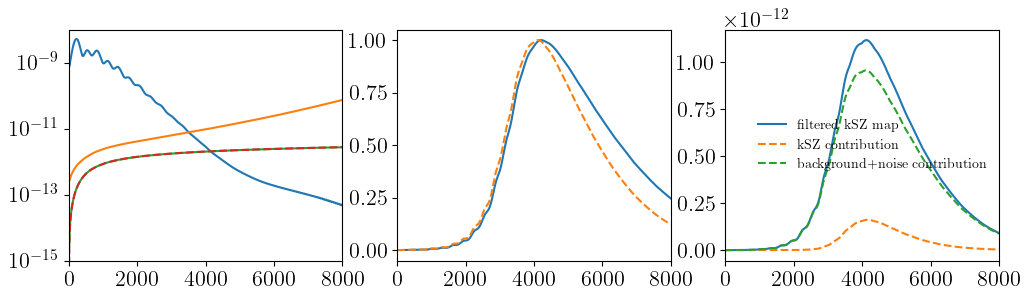

In [68]:
fig = plt.figure(figsize=(12,3))

plt.subplot(1,3,1)

plt.plot(ls, Dl_TT / (2*np.pi))
plt.plot(ls, ls*(ls+1)*Nl / (2*np.pi))
plt.plot(l_list_kSZ, l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ_nobeam / (2*np.pi))
plt.plot(ls, ls*(ls+1)*ClkSZ_itp / (2*np.pi), '--')

plt.yscale('log')

plt.xlim([0, 8000])
plt.ylim([1e-15, 1e-8])

plt.subplot(1,3,2)
plt.plot(ls, fl / np.max(fl))
plt.plot(ls, fl * beam / np.max(fl*beam), '--')
# plt.plot(ls, fl * beam, '-')
# plt.vlines([2500, 5000], ymin=0, ymax=1, colors='gray', alpha=0.5, linestyles='--')
plt.xlim([0,8000])

plt.subplot(1,3,3)
Dl_kSZ_filtered = fl**2 * beam**2 * ( Dl_TT + ls*(ls+1)*(Nl + ClkSZ_itp) )
plt.plot(ls, Dl_kSZ_filtered, label='filtered kSZ map')
plt.plot(ls, fl**2 * beam**2 *ls*(ls+1) * ClkSZ_itp, '--', label='kSZ contribution')
plt.plot(ls, Dl_kSZ_filtered - fl**2 * beam**2 *ls*(ls+1) * ClkSZ_itp, '--', label='background+noise contribution')
plt.legend(fontsize = 10, frameon=False)

plt.xlim([0,8000])

plt.show()

In [69]:
Fl_and_l_extend = np.vstack([
    np.hstack([[0., 1.], ls, [8001., 1e6]]),
    np.hstack([[0., 0.], fl * beam, [0., 0.]])
])
np.save('Data/Fl_and_l_kSZ_CMBHD.npy', Fl_and_l_extend)


Cl_kSZ_filtered = Dl_kSZ_filtered / (ls * (ls + 1)) / (2.7)**2 # dimensionless
np.save('Data/kSZ_effect/Cl_kSZ_filtered_CMBHD.npy', Cl_kSZ_filtered)

### Compare

In [107]:
_, Fl_ACT = np.load('Data/Fl_and_l_kSZ.npy')
_, Fl_SO = np.load('Data/Fl_and_l_kSZ_SO.npy')
_, Fl_CMBS4 = np.load('Data/Fl_and_l_kSZ_CMBS4.npy')
_, Fl_CMBHD = np.load('Data/Fl_and_l_kSZ_CMBHD.npy')

In [108]:
ls = np.arange(CMB_angular['total'].shape[0])[2:-50]

kSZ_obj.set_theta_FWHM_CMB(1.4/60.)
beam = np.array(kSZ_obj.Beam_kSZ(tc.tensor(ls)))
kSZ_obj.set_theta_FWHM_CMB(10./3660.)
beam_HD = np.array(kSZ_obj.Beam_kSZ(tc.tensor(ls)))

l_list_kSZ = tc.tensor(np.geomspace(10, 1e5, 101))
Cl_kSZ = tc.tensor(np.load('Data/kSZ_effect/Cl_kSZ.npy')) * (2.7)**2 
Cl_kSZ_nobeam = Cl_kSZ / kSZ_obj.Beam_kSZ(l_list_kSZ)**2

def Cl_kSZ_itp(llist):
    return np.interp(llist, l_list_kSZ, Cl_kSZ_nobeam)

ClkSZ_itp = Cl_kSZ_itp(ls)

In [109]:
DeltaT = 1e-5 * np.pi / 180 / 60 # in unit of K
Nl_ACT = DeltaT**2 * beam**(-2)
# DeltaT = 6e-6 * np.pi / 180 / 60 # in unit of K
# Nl_SO = DeltaT**2 * beam**(-2)
# DeltaT = 2e-6 * np.pi / 180 / 60 # in unit of K
# Nl_CMBS4 = DeltaT**2 * beam**(-2)
# DeltaT = 6e-7 * np.pi / 180 / 60 # in unit of K
# Nl_CMBHD = DeltaT**2 * beam**(-2)
Nl_SO = np.load('Data/ILC-Nl_SO.npy') * beam**(-2)
Nl_CMBS4 = np.load('Data/ILC-Nl_CMBS4.npy') * beam**(-2)
Nl_CMBHD = np.load('Data/ILC-Nl_CMBHD.npy') * beam_HD**(-2)

Fl_ACT = ClkSZ_itp / (ClkSZ_itp + Dl_TT/(ls* (ls + 1)) + Nl_ACT) * beam
Fl_SO = ClkSZ_itp / (ClkSZ_itp + Dl_TT/(ls* (ls + 1)) + Nl_SO) * beam
Fl_CMBS4 = ClkSZ_itp / (ClkSZ_itp + Dl_TT/(ls* (ls + 1)) + Nl_CMBS4) * beam
Fl_CMBHD = ClkSZ_itp / (ClkSZ_itp + Dl_TT/(ls* (ls + 1)) + Nl_CMBHD) * beam_HD

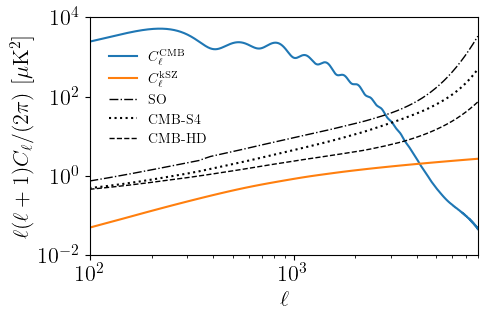

In [98]:
fig = plt.figure(figsize=(5,3.09), dpi=100)

plt.plot(ls, Dl_TT / (2*np.pi) * 1e12, label = r'$C_{\ell}^{\mathrm{CMB}}$')
plt.plot(l_list_kSZ, l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ_nobeam / (2*np.pi) * 1e12, label = r'$C_{\ell}^{\mathrm{kSZ}}$')
# plt.plot(ls, 1.38*(ls/3000)**0.21, label = r'$C_{\ell}^{\mathrm{kSZ}}$')

# plt.plot(ls, ls*(ls+1)*Nl_ACT * 1e12 / (2*np.pi), c='k', ls='--', lw=1, label = r'ACT')
plt.plot(ls, ls*(ls+1)*Nl_SO * 1e12 / (2*np.pi), c='k', ls='-.', lw=1 , label = r'SO')
plt.plot(ls, ls*(ls+1)*Nl_CMBS4 * 1e12 / (2*np.pi), c='k', ls=':', lw=1.5 , label = r'CMB-S4')
plt.plot(ls, ls*(ls+1)*Nl_CMBHD * 1e12 / (2*np.pi), c='k', ls='--', lw=1 , label = r'CMB-HD')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell (\ell + 1) C_\ell / (2\pi) ~ [\mu \mathrm{K}^2] $')

plt.xlim([100, 8000])
plt.ylim([1e-2, 1e4])
plt.legend(fontsize=10, frameon=False, bbox_to_anchor=(0.33,0.41))

plt.savefig('Figs/Cl_kSZ_more.pdf', bbox_inches = 'tight')

plt.show()

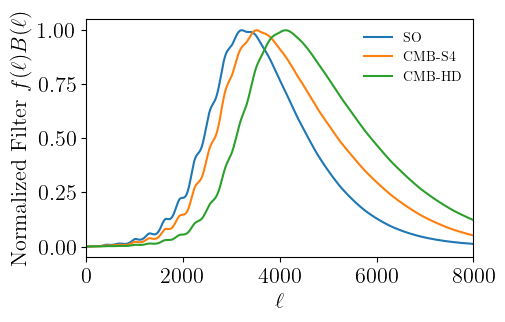

In [110]:
fig = plt.figure(figsize=(5,3.09), dpi=100)

# plt.plot(ls, Fl_ACT / np.max(Fl_ACT), label='ACT')
plt.plot(ls, Fl_SO / np.max(Fl_SO), label='SO')
plt.plot(ls, Fl_CMBS4 / np.max(Fl_CMBS4), label='CMB-S4')
plt.plot(ls, Fl_CMBHD / np.max(Fl_CMBHD), label='CMB-HD')

plt.xlabel(r'$\ell$')
plt.ylabel(r'Normalized Filter $f(\ell)B(\ell)$')

plt.xlim([0, 8000])
plt.legend(fontsize=10, frameon=False)

plt.savefig('Figs/Filter_more.pdf', bbox_inches = 'tight')

plt.show()